In [14]:
# import sys
# !{sys.executable} -m pip install tensorflow

In [81]:
from keras.datasets import fashion_mnist
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [71]:
# Load the train and test set
(train_X,train_y), (test_X,test_y) = fashion_mnist.load_data()
print('Training set shape', train_X.shape, train_y.shape)
print('Testing set shape', test_X.shape, test_y.shape)

Training set shape (60000, 28, 28) (60000,)
Testing set shape (10000, 28, 28) (10000,)


* Training set contains 60000 X 28 X 28 (60,000 images of size 28 X 28). This are all blackwhite images
* Testing set contains 10000 X 28 X 28 (10,000 images of size 28 X 28).

In [72]:
# Finding the information regarding the labels
classes = np.unique(train_y)

In [73]:
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

There are 10 classes. Checking how the train_X looks like

Text(0.5,1,'2')

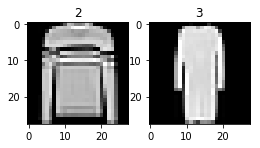

In [74]:
plt.figure(figsize=[4,4])
plt.subplot(122)
plt.imshow(train_X[25,:,:], cmap='gray')
# print label
plt.title(train_y[25])

plt.subplot(121)
plt.imshow(train_X[5,:,:], cmap='gray')
# print label
plt.title(train_y[5])

In order to feed the images into the model, we need to convert 28 X 28 into a 3D tensor of shape (sample, height, width, channel). Also, we need to standardize the data to be in 0,1 range.

Also, since the data in the int8 format, we need to change it to float32 format

In [118]:
def tensor3D(data, no_samples, height, width, channel):
    '''
    Input Params
    data: train set / test set
    no_sample: number of records or images the dataset has
    height: height of the image
    width: width of the image
    channel: number of channels (1,2,3)
    
    Output Params
    data_tensor: data in tensor format and scaled between 0 and 1
    '''
    data = data.reshape(no_samples, height, width, channel)
    data = data.astype('float32')
    data_tensor = data / 255
    return data_tensor

In [120]:
train_X = tensor3D(train_X, 60000,28,28,1)
test_X = tensor3D(test_X, 10000,28,28,1)

ValueError: cannot reshape array of size 37632000 into shape (60000,28,28,1)

In [76]:
train_X.shape, test_X.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Now we convert y labels into one-hot encodings. Per this, we create a vector of 10 elements. 10 refers here the number of classes. So for a label of class 2, the representation would be [0,0,1,0,0,0,0,0,0,0]. This is done to support the machine learning algos.

In [77]:
train_y_onehot = to_categorical(train_y)
test_y_onehot = to_categorical(test_y)

In [80]:
# Seeing how the labels have changes
print('Initial', train_y[7])
print('After one hot encoding', train_y_onehot[7])

Initial 2
After one hot encoding [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [82]:
# Dividing the train dataset into train, validation
train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_y_onehot, \
                                                              test_size=0.2, random_state=1222)
train_X.shape, valid_X.shape

((48000, 28, 28, 1), (12000, 28, 28, 1))

### Model Architecture

Input size: 28 X 28 X 1

* First Layer
    * We use 32 3X3 filters(kernels)
    * To regularize, we use Max pooling 2X2
* Second Layer
    * We use 64 3X3 filters(kernels)
    * To regularize, we use Max pooling 2X2
* Third Layer
    * We use 128 3X3 filters(kernels)
    * To regularize, we use Max pooling 2X2
    
* Flattening process
* Dense layer of 128 units
* Output layer 10 units

In [83]:
# Model Developement
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

We will use a batch size of 64. Batch size in which size groups should be feed the data into the model. Epoch defines the number of passes of the data. We keep that value to be 20

In [92]:
batch_size = 64
epochs = 20
no_classes = 10

In [86]:
model = Sequential()
# first layer
model.add(Conv2D(32, kernel_size=(3,3), activation='linear', input_shape=(28,28,1), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2,2), padding='same'))
# second layer
model.add(Conv2D(64, kernel_size=(3,3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2,2), padding='same'))
# third layer
model.add(Conv2D(128, kernel_size=(3,3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2,2), padding='same'))
# flatten
model.add(Flatten())
# Dense layer
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(no_classes, activation='softmax'))

In [97]:
# Model compilation
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [98]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         73856     
__________

In [99]:
model_train = model.fit(train_X, train_label, \
                        batch_size=batch_size, epochs=epochs, \
                        verbose=1, validation_data=(valid_X, valid_label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 122s 3ms/step - loss: 0.4671 - acc: 0.8281 - val_loss: 0.3304 - val_acc: 0.8781
Epoch 2/20
48000/48000 [==============================] - 111s 2ms/step - loss: 0.2912 - acc: 0.8949 - val_loss: 0.2638 - val_acc: 0.9042
Epoch 3/20
48000/48000 [==============================] - 107s 2ms/step - loss: 0.2431 - acc: 0.9113 - val_loss: 0.2452 - val_acc: 0.9107
Epoch 4/20
48000/48000 [==============================] - 182s 4ms/step - loss: 0.2094 - acc: 0.9226 - val_loss: 0.2368 - val_acc: 0.9162
Epoch 5/20
48000/48000 [==============================] - 10877s 227ms/step - loss: 0.1824 - acc: 0.9320 - val_loss: 0.2346 - val_acc: 0.9166
Epoch 6/20
48000/48000 [==============================] - 8135s 169ms/step - loss: 0.1624 - acc: 0.9401 - val_loss: 0.2334 - val_acc: 0.9179
Epoch 7/20
48000/48000 [==============================] - 108s 2ms/step - loss: 0.1380 - acc: 0.9485 - val_loss: 0.

Here this is the case of overfitting since the model's training accuracy is 98.96% while its validation accuracy is 91.77%.

- Let us see how the model performs on the test set, too.

In [100]:
test_eval = model.evaluate(test_X, test_y_onehot)

10000/10000 [==============================] - 6s 614us/step


In [102]:
print('Test Loss', test_eval[0])
print('Test Acc', test_eval[1])

Test Loss 0.49756758985807537
Test Acc 0.9176


In [108]:
train_acc, train_loss, valid_acc, valid_loss = model_train.history['acc'], model_train.history['loss'], model_train.history['val_acc'], model_train.history['val_loss']
epoch_pass = range(epochs)

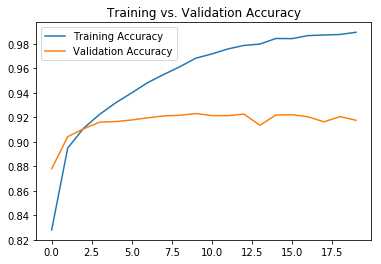

In [126]:
plt.plot(epoch_pass, train_acc, label='Training Accuracy')
plt.plot(epoch_pass, valid_acc, label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.show()

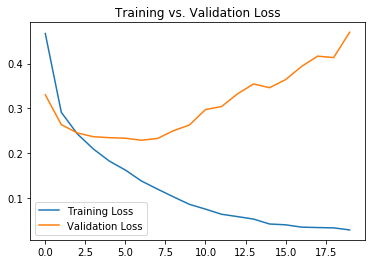

In [125]:
plt.plot(epoch_pass, train_loss, label='Training Loss')
plt.plot(epoch_pass, valid_loss, label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

We notice that after 4-5 epochs, the validation accuracy becomes stagnant and the validation loss also has become worse. It seems that model has learnt the training set.

### Dropout Layer

Dropout layer will help us curb the problem of overfittng by removing a fraction of neurons from the training process. This will refrain the model from learning the patterns since different nuerons are active in each epoch. Changing the model architecture.

In [127]:
model = Sequential()
# first layer
model.add(Conv2D(32, kernel_size=(3,3), activation='linear', input_shape=(28,28,1), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Dropout(0.25))
# second layer
model.add(Conv2D(64, kernel_size=(3,3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Dropout(0.25))
# third layer
model.add(Conv2D(128, kernel_size=(3,3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Dropout(0.40))
# flatten
model.add(Flatten())
# Dense layer
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))
model.add(Dense(no_classes, activation='softmax'))

In [128]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [129]:
# Model compilation
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [130]:
model_train = model.fit(train_X, train_label, \
                        batch_size=batch_size, epochs=epochs, \
                        verbose=1, validation_data=(valid_X, valid_label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 123s 3ms/step - loss: 0.6201 - acc: 0.7705 - val_loss: 0.3772 - val_acc: 0.8634
Epoch 2/20
48000/48000 [==============================] - 108s 2ms/step - loss: 0.3849 - acc: 0.8622 - val_loss: 0.3085 - val_acc: 0.8888
Epoch 3/20
48000/48000 [==============================] - 106s 2ms/step - loss: 0.3343 - acc: 0.8769 - val_loss: 0.2806 - val_acc: 0.8928
Epoch 4/20
48000/48000 [==============================] - 242s 5ms/step - loss: 0.3057 - acc: 0.8880 - val_loss: 0.2514 - val_acc: 0.9085
Epoch 5/20
48000/48000 [==============================] - 412s 9ms/step - loss: 0.2882 - acc: 0.8936 - val_loss: 0.2521 - val_acc: 0.9052
Epoch 6/20
48000/48000 [==============================] - 118s 2ms/step - loss: 0.2744 - acc: 0.8984 - val_loss: 0.2315 - val_acc: 0.9141
Epoch 7/20
48000/48000 [==============================] - 257s 5ms/step - loss: 0.2640 - acc: 0.9016 - val_loss: 0.2288 - 

In [131]:
model.save('fashion_mnish.h5')

In [133]:
test_eval = model.evaluate(test_X, test_y_onehot, verbose=1)

10000/10000 [==============================] - 8s 784us/step


In [134]:
print('Test Loss', test_eval[0])

Test Loss 0.2168282817900181


In [135]:
print('Test Accuracy', test_eval[1])

Test Accuracy 0.9179


Not much improvement on the accuracy but we a good improvement on the test loss. Also, looking at the training and validation loss and accuracy.

In [137]:
train_acc, train_loss, valid_acc, valid_loss = model_train.history['acc'], model_train.history['loss'], model_train.history['val_acc'], model_train.history['val_loss']
epoch_pass = range(epochs)

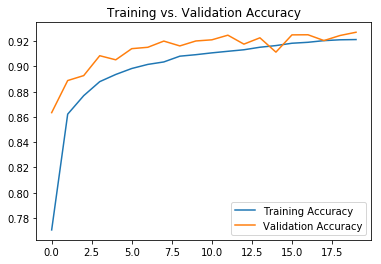

In [138]:
plt.plot(epoch_pass, train_acc, label='Training Accuracy')
plt.plot(epoch_pass, valid_acc, label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.show()

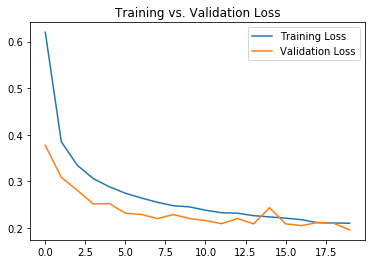

In [139]:
plt.plot(epoch_pass, train_loss, label='Training Loss')
plt.plot(epoch_pass, valid_loss, label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

In [140]:
pred_labels = model.predict(test_X)

We can convert pred_labels to their max probabilites

In [163]:
pred_classes = []
for i in range(len(pred_labels)):
    max_prob = pred_labels[i].argmax()
    pred_classes.append(max_prob)
pred_classes = np.array(pred_classes)

In [169]:
pred_classes

array([9, 2, 1, ..., 8, 1, 5])

In [154]:
test_y

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [171]:
pred_classes == test_y

array([ True,  True,  True, ...,  True,  True,  True])

In [193]:
# Seeing how many were correctly identified
match = pred_classes == test_y
correct_labels =len(match[match==True])
incorrect_labels = len(match[match==False])

In [194]:
print('correctly identified labels', correct_labels)
print('incorrectly identified labels', incorrect_labels)

correctly identified labels 9179
incorrectly identified labels 821


No of correct labels 9179


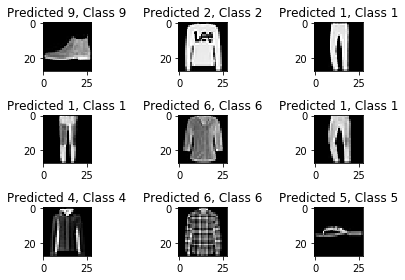

In [215]:
correct = np.where(pred_classes==test_y)[0]
print ("No of correct labels", len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(pred_classes[correct], test_y[correct]))
    plt.tight_layout()

No of incorrect labels 821


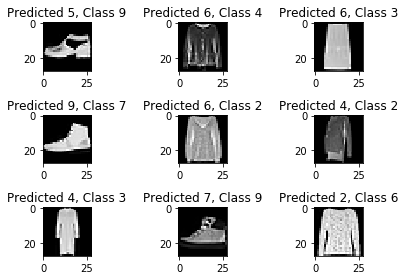

In [216]:
incorrect = np.where(pred_classes!=test_y)[0]
print ("No of incorrect labels", len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(pred_classes[incorrect], test_y[incorrect]))
    plt.tight_layout()

#### End of code